In [3]:
from datasets import load_dataset
from tqdm import tqdm
from parser import remove_comments_and_docstrings
import pandas as pd
tqdm.pandas()
import numpy as np
from parser import DFG_python,DFG_java,DFG_ruby,DFG_go,DFG_php,DFG_javascript,DFG_csharp
from parser import (remove_comments_and_docstrings,
                   tree_to_token_index,
                   index_to_code_token,
                   tree_to_variable_index, 
                   detokenize_code, tree_to_token_nodes)
from tree_sitter import Language, Parser
import pickle
import os
from transformers import RobertaTokenizer
import matplotlib.pyplot as plt


def read_pt_dataset(max_samples_per_split=None):
    dataset = load_dataset('code_search_net')
    rows = []
    
    for split in ['train', 'test', 'validation']:
        num_samples_in_split = len(dataset[split])
        indices = list(range(num_samples_in_split))
        if (max_samples_per_split is not None) and (num_samples_in_split>max_samples_per_split):
            indices = list(map(int, np.random.choice(indices, max_samples_per_split, replace=False)))
        pbar = tqdm(indices)
        pbar.set_description('Reading split='+split)
        
        for i in pbar:
            sample = dataset[split][i]
            rows.append([sample['func_code_string'], sample['language'], 
                         sample['func_documentation_string']])
            
    return pd.DataFrame(rows, columns=['code', 'lang', 'text'])


def add_php_ends(code):
    if not(code.startswith('<?php')):
        code="<?php "+code
    if not(code.endswith('?>')):
        code=code+"?>" 
    return code


def print_lang_dist(langs, total=None):
    if total is None:
        total = len(langs)
    vc = pd.value_counts(langs)
    display(pd.DataFrame({'lang':vc.index, 'count':vc.values, 'perc':vc.values/total*100}))

    
def get_tokenizer_chars():
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    tokenizer_chars = []
    for i in range(tokenizer.vocab_size):
        token = tokenizer.decode(i)
        if len(token)==1:
            tokenizer_chars.append(token)
    tokenizer_chars = [c for c in tokenizer_chars if c!='�']
    return tokenizer_chars
    

def preprocess(data):
    codes = []
    failed_count = 0
    failed_langs = []
    rows = []
    tokenizer_chars = get_tokenizer_chars()
    pbar = tqdm(data.itertuples())
    for row in pbar:
        code = row.code.strip().replace('▁', '_').replace('\r\n', '\n') # step 1
        code = ''.join(filter(lambda c:c in tokenizer_chars, code)) # step 2
        if row.lang=="php":
            code = add_php_ends(code) # step 3
        try:
            code = remove_comments_and_docstrings(code, row.lang) # step 4
        except:
            failed_count += 1
            failed_langs.append(row.lang)
            pbar.set_description('failed_count='+str(failed_count))
            continue
        rows.append([code, row.lang, row.text.strip()])
    if failed_count:
        print ('Distribution of languages among failed samples for remove_comments_and_docstrings()')
        print_lang_dist(failed_langs)
    data = pd.DataFrame(rows, columns=['code', 'lang', 'text'])
    print ('Distribution of languages after removing samples failing remove_comments_and_docstrings()')
    print_lang_dist(data.lang)
    return data


def extract_structure(code, parser):
    # ast
    tree = parser[0].parse(bytes(code,'utf8'))    
    root_node = tree.root_node  
    ast_token_nodes = tree_to_token_nodes(root_node) # leaves
    
    # dfg
    tokens_index = [(node.start_point, node.end_point) for node in ast_token_nodes]
    code=code.split('\n')
    code_tokens=[index_to_code_token(x,code) for x in tokens_index] 
    index_to_code={index:(idx,code_) for idx,(index,code_) in enumerate(zip(tokens_index,code_tokens))}
    try:
        DFG,_ = parser[1](root_node,index_to_code,{}) 
    except:
        DFG = []
    for d in DFG:
        assert (d[2]=='comesFrom' or d[2]=='computedFrom')
    DFG = [(d[1], d[4]) for d in DFG if (len(d[4])>0)] # left comes from right
    return code_tokens, ast_token_nodes, DFG


def format_node_ranges(code, nodes):
    line_lens = [len(line)+1 for line in code.split('\n')]
    line_starts = [0] + list(np.cumsum(line_lens))
    return [(line_starts[node.start_point[0]]+node.start_point[1],
             line_starts[node.end_point[0]]+node.end_point[1]) for node in nodes]

    
def length_stats(s, title=None):
    try:
        if type(s.iloc[0])==str: # a list encoded as str
            lens = s.apply(lambda x:x.count(',')+1)
        else: # a list
            lens = s.apply(len)
    except:
        lens = s # s contains lengths
    y = np.arange(100)
    x = lens.quantile(y/100)
    plt.figure()
    plt.plot(x,y)
    plt.title(title)
    plt.show()
    
    
def add_structure(data):
    dfg_function={
    'python':DFG_python,
    'java':DFG_java,
    'php':DFG_php,
    'javascript':DFG_javascript,
    'go':DFG_go,
    'ruby':DFG_ruby
    }

    parsers={}        
    for lang in dfg_function:
        LANGUAGE = Language('parser/my-languages2.so', lang)
        parser = Parser()
        parser.set_language(LANGUAGE) 
        parser = [parser,dfg_function[lang]]    
        parsers[lang]= parser
        
    ast_leaf_tokens, ast_leaves, ast_leaf_ranges, dfg_edges = [], [], [], []
    for row in tqdm(data.itertuples()):
        curr_code_tokens, curr_ast_leaves, curr_dfg_edges = extract_structure(row.code, parsers[row.lang])
        ast_leaf_tokens.append(curr_code_tokens)
        ast_leaves.append(curr_ast_leaves)
        ast_leaf_ranges.append(format_node_ranges(row.code, curr_ast_leaves))
        dfg_edges.append(curr_dfg_edges)
        
    data['ast_leaves'] = ast_leaves # list of leaf nodes
    data['dfg_edges'] = dfg_edges # list of "left leaf node index comes from right leaf nodes indices"
    data['ast_leaf_tokens'] = ast_leaf_tokens # list of code substrings corresponding to each leaf
    data['ast_leaf_ranges'] = ast_leaf_ranges # list of (start,end) in code for each leaf node
    
    print ('Distribution of languages among codes with failed/empty DFG')
    print_lang_dist(data.loc[data['dfg_edges'].apply(len)==0].lang, total=len(data))
    
    
def tokenize_codes_texts(texts, batch_size=1024):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    N = len(texts)
    tokenized_texts = []
    for start in tqdm(range(0, len(texts),batch_size)):
        tokenized_texts += tokenizer(texts[start:start+batch_size]).input_ids
    return tokenized_texts

    
def get_code_tokens_ranges(data):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    match  = {lang:[0,0] for lang in data['lang'].unique()}
    pbar = tqdm(data.itertuples())
    ranges = []
    
    for row in pbar:
        code_tokens = [tokenizer.decode(ct) for ct in row.code_tokens][1:-1] # 1:-1 to remove <s> and </s>
        code2 = ''.join(code_tokens) # misses some spaces that are in row.code
        code = row.code
        
        # map each position in code2 to a position in code
        code2_to_code = []
        j=0
        for i in range(len(code2)):
            if code2[i]==code[j]:
                code2_to_code.append(j)
                j += 1
            elif code2[i]==code[j+1]: # if code2 missed a space
                code2_to_code.append(j+1)
                j += 2
            else:
                raise Exception('Character "'+code2[i]+'" from tokenized code not found in code.')
            
        # map each code token to a range in code
        code2_idx = 0
        curr_ranges = []
        for ct in code_tokens:
            s,e = code2_idx, code2_idx+len(ct)
            code2_idx = e
            curr_ranges.append((min(code2_to_code[s:e]),1+max(code2_to_code[s:e])))
        ranges.append([None]+curr_ranges+[None]) # first and last for <s> and </s>
        
    data['code_tokens_ranges'] = ranges
    
    
def overlap(s1,e1,s2,e2):
    return s1<=s2<e1 or s2<=s1<e2
    
def get_leaf_code_token_indices(data):
    ast_leaf_token_idxs = []
    for row in tqdm(data.itertuples()):
        j = 1
        ast_leaf_token_idxs.append([])
        code_tokens_last_idx = len(row.code_tokens)-1
        for s,e in row.ast_leaf_ranges:
            if s==e: # there are leaves with start_point=end_point
                ast_leaf_token_idxs[-1].append([])
                continue
            while not(overlap(s,e,row.code_tokens_ranges[j][0],row.code_tokens_ranges[j][1])):
                j += 1
            jj = j
            curr_leaf_token_idxs = []
            while overlap(s,e,row.code_tokens_ranges[jj][0],row.code_tokens_ranges[jj][1]):
                curr_leaf_token_idxs.append(jj)
                jj += 1
                if jj==code_tokens_last_idx:
                    break
            ast_leaf_token_idxs[-1].append(curr_leaf_token_idxs)
    data['ast_leaf_code_token_idxs'] = ast_leaf_token_idxs
    

def get_lr_path(leaf):
    path = [leaf]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return path


def get_ll_sim(p1, p2): 
    common = 1
    for i in range(2, min(len(p1), len(p2))+1):
        if p1[-i]==p2[-i]:
            common += 1
        else:
            break
    return common*common / (len(p1)*len(p2))   


def process_dfg_edges(data):
    dfg_node_code_token_idxs = []
    dfg_edges = []
    for row in tqdm(data.itertuples()):
        if len(row.dfg_edges)>0:
            nodes = sorted(list(set(np.concatenate([[left]+right for left,right in row.dfg_edges]))))
        else:
            nodes = []
        node_to_idx = {k:i for i,k in enumerate(nodes)}
        dfg_node_code_token_idxs.append( [row.ast_leaf_code_token_idxs[i] for i in nodes] )
        dfg_edges.append( [(node_to_idx[left], [node_to_idx[r] for r in right]) for left,right in row.dfg_edges] )
    data['dfg_edges'] = dfg_edges
    data['dfg_node_code_token_idxs'] = dfg_node_code_token_idxs
    
def get_ast_lr_paths_and_ll_sim(data):
    sims = []
    lr_paths = []
    all_node_types = set()
    for i,row in tqdm(enumerate(data.itertuples())):
        L = min(len(row.ast_leaves), 512)
        curr_paths = [get_lr_path(leaf) for leaf in row.ast_leaves]
        curr_sims = np.ones((L,L))
        for i in range(L-1):
            for j in range(i+1,L):
                curr_sims[i,j] = curr_sims[j,i] = get_ll_sim(curr_paths[i], curr_paths[j])
        sims.append(';'.join([','.join(list(map(str,row))) for row in curr_sims]))
        lr_paths.append([[node.type for node in path] for path in curr_paths])
        all_node_types.update(set(np.concatenate(lr_paths[-1])))
    data.drop(columns=['ast_leaves'], inplace=True)
    data['ll_sims'] = sims
    data['lr_paths_types'] = lr_paths
    return all_node_types

def parse_list_of_lists(s, type_=int):
    list_of_lists = s[1:-2].split('], ')
    if type_==str:
        list_of_lists = [[t[1:-1].replace('\\n','\n').replace('\\\\','\\') for  t in x[1:].split(', ')] \
                         for x in list_of_lists]
    elif type_==int:
        list_of_lists = [[int(t) for  t in x[1:].split(', ')] for x in list_of_lists]
    else:
        raise Exception('Unknown value for type_')
    return list_of_lists

No config specified, defaulting to: code_search_net/all
Found cached dataset code_search_net (/home/tsaisindhura/.cache/huggingface/datasets/code_search_net/all/1.0.0/80a244ab541c6b2125350b764dc5c2b715f65f00de7a56107a28915fac173a27)
Reading split=validation: 100%|█████████████████████████████████████████████████| 89154/89154 [00:14<00:00, 6112.06it/s]
failed_count=2: : 2070536it [24:51, 1387.81it/s]

Distribution of languages among failed samples for remove_comments_and_docstrings()


,lang,count,perc
0,python,2,100.0


Distribution of languages after removing samples failing remove_comments_and_docstrings()


,lang,count,perc
0,php,578118,27.921203
1,java,496688,23.988401
2,python,457459,22.093769
3,go,346365,16.728293
4,javascript,138625,6.695133
5,ruby,53279,2.573201


2070534it [39:44, 868.23it/s] 


Distribution of languages among codes with failed/empty DFG


,lang,count,perc
0,php,32294,1.559694
1,java,4655,0.224821
2,go,1989,0.096062
3,javascript,1120,0.054092
4,ruby,543,0.026225
5,python,285,0.013765


100%|███████████████████████████████████████████████████████████████████████████████| 2023/2023 [10:59<00:00,  3.07it/s]


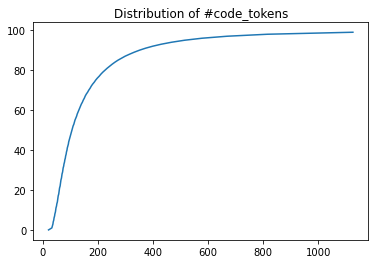

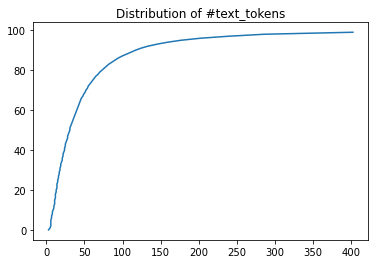

2070534it [31:17, 1102.90it/s]
2070534it [19:34, 1763.01it/s] 
100%|█████████████████████████████████████████████████████████████████████| 2070534/2070534 [00:14<00:00, 145034.98it/s]


Working on from_0.parquet


10000it [04:20, 38.44it/s]
10000it [00:00, 11158.24it/s]


Working on from_10000.parquet


10000it [04:12, 39.61it/s]
10000it [00:01, 9327.23it/s]


Working on from_20000.parquet


10000it [04:19, 38.59it/s]
10000it [00:01, 9834.14it/s]


Working on from_30000.parquet


10000it [04:25, 37.68it/s]
10000it [00:01, 9210.77it/s]


Working on from_40000.parquet


10000it [04:10, 39.98it/s]
10000it [00:00, 11353.22it/s]


Working on from_50000.parquet


10000it [04:04, 40.90it/s]
10000it [00:00, 10931.55it/s]


Working on from_60000.parquet


10000it [04:01, 41.38it/s]
10000it [00:00, 10758.59it/s]


Working on from_70000.parquet


10000it [03:51, 43.15it/s]
10000it [00:00, 10930.26it/s]


Working on from_80000.parquet


10000it [03:59, 41.70it/s]
10000it [00:00, 10168.56it/s]


Working on from_90000.parquet


10000it [04:03, 41.05it/s]
10000it [00:00, 11145.01it/s]


Working on from_100000.parquet


10000it [04:01, 41.38it/s]
10000it [00:00, 10820.39it/s]


Working on from_110000.parquet


10000it [03:50, 43.36it/s]
10000it [00:00, 11545.92it/s]


Working on from_120000.parquet


10000it [04:08, 40.31it/s]
10000it [00:00, 10826.48it/s]


Working on from_130000.parquet


10000it [03:56, 42.37it/s]
10000it [00:01, 9807.11it/s]


Working on from_140000.parquet


10000it [03:54, 42.70it/s]
10000it [00:00, 11366.35it/s]


Working on from_150000.parquet


10000it [03:55, 42.46it/s]
10000it [00:00, 10859.17it/s]


Working on from_160000.parquet


10000it [04:00, 41.61it/s]
10000it [00:00, 11158.38it/s]


Working on from_170000.parquet


10000it [03:51, 43.16it/s]
10000it [00:00, 11739.76it/s]


Working on from_180000.parquet


10000it [03:49, 43.67it/s]
10000it [00:00, 11249.10it/s]


Working on from_190000.parquet


10000it [03:39, 45.50it/s]
10000it [00:00, 11432.20it/s]


Working on from_200000.parquet


10000it [03:45, 44.35it/s]
10000it [00:00, 11757.06it/s]


Working on from_210000.parquet


10000it [03:58, 41.88it/s]
10000it [00:00, 10581.68it/s]


Working on from_220000.parquet


10000it [03:59, 41.76it/s]
10000it [00:00, 10672.04it/s]


Working on from_230000.parquet


10000it [03:48, 43.78it/s]
10000it [00:00, 11846.81it/s]


Working on from_240000.parquet


10000it [04:00, 41.53it/s]
10000it [00:00, 11294.38it/s]


Working on from_250000.parquet


10000it [04:10, 39.88it/s]
10000it [00:01, 9103.56it/s]


Working on from_260000.parquet


10000it [04:12, 39.65it/s]
10000it [00:01, 9460.41it/s]


Working on from_270000.parquet


10000it [04:16, 39.06it/s]
10000it [00:00, 10340.76it/s]


Working on from_280000.parquet


10000it [04:34, 36.43it/s]
10000it [00:00, 11614.05it/s]


Working on from_290000.parquet


10000it [04:10, 39.96it/s]
10000it [00:00, 10367.76it/s]


Working on from_300000.parquet


10000it [04:04, 40.93it/s]
10000it [00:00, 10903.52it/s]


Working on from_310000.parquet


10000it [04:15, 39.14it/s]
10000it [00:00, 11475.71it/s]


Working on from_320000.parquet


10000it [04:07, 40.46it/s]
10000it [00:00, 10484.51it/s]


Working on from_330000.parquet


10000it [04:01, 41.48it/s]
10000it [00:01, 9086.57it/s]


Working on from_340000.parquet


10000it [03:55, 42.47it/s]
10000it [00:00, 11191.68it/s]


Working on from_350000.parquet


10000it [03:50, 43.34it/s]
10000it [00:00, 11981.28it/s]


Working on from_360000.parquet


10000it [03:44, 44.61it/s]
10000it [00:00, 11726.14it/s]


Working on from_370000.parquet


10000it [03:55, 42.38it/s]
10000it [00:00, 10891.90it/s]


Working on from_380000.parquet


10000it [03:48, 43.67it/s]
10000it [00:00, 11673.08it/s]


Working on from_390000.parquet


10000it [03:53, 42.86it/s]
10000it [00:00, 11923.78it/s]


Working on from_400000.parquet


10000it [03:54, 42.71it/s]
10000it [00:00, 12088.90it/s]


Working on from_410000.parquet


10000it [04:18, 38.75it/s]
10000it [00:00, 11440.64it/s]


Working on from_420000.parquet


10000it [03:52, 43.01it/s]
10000it [00:00, 11545.90it/s]


Working on from_430000.parquet


10000it [03:50, 43.44it/s]
10000it [00:00, 11721.36it/s]


Working on from_440000.parquet


10000it [03:45, 44.33it/s]
10000it [00:00, 10655.33it/s]


Working on from_450000.parquet


10000it [03:54, 42.71it/s]
10000it [00:00, 11573.26it/s]


Working on from_460000.parquet


10000it [03:52, 43.09it/s]
10000it [00:00, 11601.57it/s]


Working on from_470000.parquet


10000it [03:58, 41.96it/s]
10000it [00:00, 11639.42it/s]


Working on from_480000.parquet


10000it [03:39, 45.52it/s]
10000it [00:00, 12039.20it/s]


Working on from_490000.parquet


10000it [03:57, 42.13it/s]
10000it [00:00, 11573.50it/s]


Working on from_500000.parquet


10000it [03:52, 43.07it/s]
10000it [00:00, 11446.16it/s]


Working on from_510000.parquet


10000it [03:54, 42.61it/s]
10000it [00:00, 11189.96it/s]


Working on from_520000.parquet


10000it [03:50, 43.33it/s]
10000it [00:00, 11396.01it/s]


Working on from_530000.parquet


10000it [03:43, 44.71it/s]
10000it [00:00, 11648.13it/s]


Working on from_540000.parquet


10000it [03:48, 43.78it/s]
10000it [00:00, 12050.49it/s]


Working on from_550000.parquet


10000it [06:02, 27.60it/s]
10000it [00:00, 12024.22it/s]


Working on from_560000.parquet


10000it [03:38, 45.85it/s]
10000it [00:00, 12547.99it/s]


Working on from_570000.parquet


10000it [03:47, 43.92it/s]
10000it [00:00, 11592.70it/s]


Working on from_580000.parquet


10000it [03:47, 43.87it/s]
10000it [00:00, 11931.61it/s]


Working on from_590000.parquet


10000it [03:54, 42.59it/s]
10000it [00:00, 11604.36it/s]


Working on from_600000.parquet


10000it [03:58, 41.95it/s]
10000it [00:00, 11319.53it/s]


Working on from_610000.parquet


10000it [03:49, 43.48it/s]
10000it [00:00, 11555.29it/s]


Working on from_620000.parquet


10000it [03:55, 42.49it/s]
10000it [00:00, 10940.87it/s]


Working on from_630000.parquet


10000it [04:11, 39.73it/s]
10000it [00:00, 11511.88it/s]


Working on from_640000.parquet


10000it [03:49, 43.51it/s]
10000it [00:00, 11699.04it/s]


Working on from_650000.parquet


10000it [03:59, 41.73it/s]
10000it [00:00, 11520.52it/s]


Working on from_660000.parquet


10000it [03:44, 44.58it/s]
10000it [00:00, 12148.08it/s]


Working on from_670000.parquet


10000it [03:47, 43.98it/s]
10000it [00:00, 11554.63it/s]


Working on from_680000.parquet


10000it [03:49, 43.63it/s]
10000it [00:00, 10985.06it/s]


Working on from_690000.parquet


10000it [03:47, 43.89it/s]
10000it [00:00, 11942.35it/s]


Working on from_700000.parquet


10000it [03:49, 43.60it/s]
10000it [00:00, 11352.11it/s]


Working on from_710000.parquet


10000it [03:45, 44.43it/s]
10000it [00:00, 12112.83it/s]


Working on from_720000.parquet


10000it [03:48, 43.82it/s]
10000it [00:00, 11298.85it/s]


Working on from_730000.parquet


10000it [03:47, 43.97it/s]
10000it [00:00, 11249.82it/s]


Working on from_740000.parquet


10000it [03:59, 41.70it/s]
10000it [00:00, 10865.71it/s]


Working on from_750000.parquet


10000it [04:00, 41.62it/s]
10000it [00:01, 9732.69it/s]


Working on from_760000.parquet


10000it [04:13, 39.48it/s]
10000it [00:00, 11117.08it/s]


Working on from_770000.parquet


10000it [04:25, 37.61it/s]
10000it [00:00, 11245.38it/s]


Working on from_780000.parquet


10000it [03:41, 45.13it/s]
10000it [00:00, 11768.72it/s]


Working on from_790000.parquet


10000it [04:09, 40.04it/s]
10000it [00:00, 10542.04it/s]


Working on from_800000.parquet


10000it [04:43, 35.27it/s]
10000it [00:02, 3706.29it/s]


Working on from_810000.parquet


10000it [04:01, 41.44it/s]
10000it [00:00, 11195.30it/s]


Working on from_820000.parquet


10000it [03:59, 41.77it/s]
10000it [00:00, 11431.32it/s]


Working on from_830000.parquet


10000it [03:53, 42.80it/s]
10000it [00:00, 11197.06it/s]


Working on from_840000.parquet


10000it [03:56, 42.35it/s]
10000it [00:00, 11361.57it/s]


Working on from_850000.parquet


10000it [03:51, 43.17it/s]
10000it [00:00, 11501.89it/s]


Working on from_860000.parquet


10000it [03:46, 44.06it/s]
10000it [00:00, 11379.73it/s]


Working on from_870000.parquet


10000it [03:45, 44.33it/s]
10000it [00:00, 12064.03it/s]


Working on from_880000.parquet


10000it [03:45, 44.38it/s]
10000it [00:00, 10938.07it/s]


Working on from_890000.parquet


10000it [03:49, 43.59it/s]
10000it [00:00, 11296.61it/s]


Working on from_900000.parquet


10000it [03:48, 43.81it/s]
10000it [00:00, 10832.36it/s]


Working on from_910000.parquet


10000it [03:48, 43.68it/s]
10000it [00:00, 11355.44it/s]


Working on from_920000.parquet


10000it [04:05, 40.73it/s]
10000it [00:00, 11630.71it/s]


Working on from_930000.parquet


10000it [03:49, 43.50it/s]
10000it [00:00, 11541.54it/s]


Working on from_940000.parquet


10000it [03:50, 43.43it/s]
10000it [00:00, 11447.65it/s]


Working on from_950000.parquet


10000it [03:56, 42.36it/s]
10000it [00:00, 11144.91it/s]


Working on from_960000.parquet


10000it [03:53, 42.89it/s]
10000it [00:00, 11491.78it/s]


Working on from_970000.parquet


10000it [05:10, 32.24it/s]
10000it [00:00, 10585.42it/s]


Working on from_980000.parquet


10000it [04:11, 39.76it/s]
10000it [00:01, 9415.90it/s]


Working on from_990000.parquet


10000it [04:20, 38.40it/s]
10000it [00:00, 11457.11it/s]


Working on from_1000000.parquet


10000it [04:21, 38.18it/s]
10000it [00:00, 11057.28it/s]


Working on from_1010000.parquet


10000it [04:20, 38.43it/s]
10000it [00:00, 11533.62it/s]


Working on from_1020000.parquet


10000it [04:09, 40.11it/s]
10000it [00:01, 9303.18it/s]


Working on from_1030000.parquet


10000it [04:17, 38.90it/s]
10000it [00:00, 11108.97it/s]


Working on from_1040000.parquet


10000it [04:16, 38.93it/s]
10000it [00:01, 9717.12it/s]


Working on from_1050000.parquet


10000it [04:09, 40.08it/s]
10000it [00:00, 11442.70it/s]


Working on from_1060000.parquet


10000it [05:31, 30.14it/s]
10000it [00:01, 9677.60it/s]


Working on from_1070000.parquet


10000it [03:56, 42.34it/s]
10000it [00:00, 11297.76it/s]


Working on from_1080000.parquet


10000it [03:46, 44.07it/s]
10000it [00:00, 11277.67it/s]


Working on from_1090000.parquet


10000it [03:49, 43.64it/s]
10000it [00:00, 11572.75it/s]


Working on from_1100000.parquet


10000it [03:53, 42.83it/s]
10000it [00:00, 11170.32it/s]


Working on from_1110000.parquet


10000it [03:46, 44.18it/s]
10000it [00:00, 11682.99it/s]


Working on from_1120000.parquet


10000it [03:44, 44.46it/s]
10000it [00:00, 11638.00it/s]


Working on from_1130000.parquet


10000it [03:49, 43.63it/s]
10000it [00:00, 11464.68it/s]


Working on from_1140000.parquet


10000it [03:49, 43.51it/s]
10000it [00:00, 11621.46it/s]


Working on from_1150000.parquet


10000it [03:46, 44.07it/s]
10000it [00:00, 12231.83it/s]


Working on from_1160000.parquet


10000it [03:48, 43.72it/s]
10000it [00:00, 11318.46it/s]


Working on from_1170000.parquet


10000it [03:44, 44.47it/s]
10000it [00:00, 11989.07it/s]


Working on from_1180000.parquet


10000it [03:48, 43.74it/s]
10000it [00:00, 11792.23it/s]


Working on from_1190000.parquet


10000it [03:54, 42.58it/s]
10000it [00:00, 11814.34it/s]


Working on from_1200000.parquet


10000it [03:54, 42.67it/s]
10000it [00:00, 11728.97it/s]


Working on from_1210000.parquet


10000it [03:57, 42.17it/s]
10000it [00:00, 11511.80it/s]


Working on from_1220000.parquet


10000it [04:07, 40.46it/s]
10000it [00:01, 7808.96it/s]


Working on from_1230000.parquet


10000it [04:43, 35.31it/s]
10000it [00:01, 9162.89it/s]


Working on from_1240000.parquet


10000it [04:02, 41.28it/s]
10000it [00:00, 11126.37it/s]


Working on from_1250000.parquet


10000it [04:02, 41.24it/s]
10000it [00:00, 11877.98it/s]


Working on from_1260000.parquet


10000it [04:03, 41.07it/s]
10000it [00:00, 11980.15it/s]


Working on from_1270000.parquet


10000it [04:11, 39.80it/s]
10000it [00:00, 11684.49it/s]


Working on from_1280000.parquet


10000it [04:10, 39.94it/s]
10000it [00:00, 11022.65it/s]


Working on from_1290000.parquet


10000it [04:07, 40.48it/s]
10000it [00:01, 9490.16it/s]


Working on from_1300000.parquet


10000it [05:16, 31.57it/s]
10000it [00:02, 3461.24it/s]


Working on from_1310000.parquet


10000it [04:17, 38.78it/s]
10000it [00:00, 11669.02it/s]


Working on from_1320000.parquet


10000it [04:17, 38.86it/s]
10000it [00:00, 10194.16it/s]


Working on from_1330000.parquet


10000it [04:17, 38.90it/s]
10000it [00:01, 9254.17it/s]


Working on from_1340000.parquet


10000it [04:13, 39.52it/s]
10000it [00:01, 9600.79it/s]


Working on from_1350000.parquet


10000it [04:14, 39.29it/s]
10000it [00:00, 10470.18it/s]


Working on from_1360000.parquet


10000it [06:49, 24.44it/s]
10000it [00:00, 12022.46it/s]


Working on from_1370000.parquet


10000it [04:05, 40.68it/s]
10000it [00:00, 11260.14it/s]


Working on from_1380000.parquet


10000it [04:20, 38.33it/s]
10000it [00:00, 11212.26it/s]


Working on from_1390000.parquet


10000it [04:00, 41.64it/s]
10000it [00:00, 12139.85it/s]


Working on from_1400000.parquet


10000it [03:59, 41.72it/s]
10000it [00:00, 11885.70it/s]


Working on from_1410000.parquet


10000it [04:21, 38.18it/s]
10000it [00:01, 9705.02it/s]


Working on from_1420000.parquet


10000it [04:14, 39.28it/s]
10000it [00:00, 11974.55it/s]


Working on from_1430000.parquet


10000it [04:13, 39.43it/s]
10000it [00:00, 11435.96it/s]


Working on from_1440000.parquet


10000it [04:16, 38.92it/s]
10000it [00:00, 10793.17it/s]


Working on from_1450000.parquet


10000it [03:51, 43.13it/s]
10000it [00:00, 12042.86it/s]


Working on from_1460000.parquet


10000it [04:06, 40.63it/s]
10000it [00:00, 11896.31it/s]


Working on from_1470000.parquet


10000it [03:58, 41.99it/s]
10000it [00:00, 10955.21it/s]


Working on from_1480000.parquet


10000it [03:54, 42.64it/s]
10000it [00:00, 11605.88it/s]


Working on from_1490000.parquet


10000it [03:58, 42.01it/s]
10000it [00:00, 11577.33it/s]


Working on from_1500000.parquet


10000it [03:54, 42.61it/s]
10000it [00:00, 11645.37it/s]


Working on from_1510000.parquet


10000it [03:52, 43.04it/s]
10000it [00:00, 11713.85it/s]


Working on from_1520000.parquet


10000it [03:43, 44.84it/s]
10000it [00:00, 12030.21it/s]


Working on from_1530000.parquet


10000it [03:48, 43.71it/s]
10000it [00:00, 11808.52it/s]


Working on from_1540000.parquet


10000it [03:47, 43.97it/s]
10000it [00:00, 11713.31it/s]


Working on from_1550000.parquet


10000it [03:54, 42.63it/s]
10000it [00:00, 11425.09it/s]


Working on from_1560000.parquet


10000it [04:03, 41.13it/s]
10000it [00:00, 11993.29it/s]


Working on from_1570000.parquet


10000it [04:11, 39.70it/s]
10000it [00:00, 11543.72it/s]


Working on from_1580000.parquet


10000it [04:28, 37.19it/s]
10000it [00:00, 11764.26it/s]


Working on from_1590000.parquet


10000it [04:17, 38.86it/s]
10000it [00:00, 11183.54it/s]


Working on from_1600000.parquet


10000it [04:08, 40.30it/s]
10000it [00:01, 9422.10it/s]


Working on from_1610000.parquet


10000it [04:00, 41.54it/s]
10000it [00:00, 11577.94it/s]


Working on from_1620000.parquet


10000it [04:06, 40.52it/s]
10000it [00:00, 11580.84it/s]


Working on from_1630000.parquet


10000it [03:45, 44.27it/s]
10000it [00:00, 12031.75it/s]


Working on from_1640000.parquet


10000it [03:59, 41.75it/s]
10000it [00:00, 10915.98it/s]


Working on from_1650000.parquet


10000it [03:49, 43.55it/s]
10000it [00:00, 12131.20it/s]


Working on from_1660000.parquet


10000it [03:44, 44.56it/s]
10000it [00:00, 11184.23it/s]


Working on from_1670000.parquet


10000it [03:42, 44.96it/s]
10000it [00:00, 12015.03it/s]


Working on from_1680000.parquet


10000it [03:55, 42.44it/s]
10000it [00:01, 9647.13it/s]


Working on from_1690000.parquet


10000it [04:12, 39.54it/s]
10000it [00:00, 11549.20it/s]


Working on from_1700000.parquet


10000it [04:12, 39.64it/s]
10000it [00:00, 11584.08it/s]


Working on from_1710000.parquet


10000it [04:14, 39.36it/s]
10000it [00:00, 11697.73it/s]


Working on from_1720000.parquet


10000it [03:57, 42.09it/s]
10000it [00:00, 11499.67it/s]


Working on from_1730000.parquet


10000it [03:57, 42.07it/s]
10000it [00:01, 9489.89it/s]


Working on from_1740000.parquet


10000it [04:04, 40.97it/s]
10000it [00:01, 8790.15it/s]


Working on from_1750000.parquet


10000it [03:52, 42.94it/s]
10000it [00:00, 11241.33it/s]


Working on from_1760000.parquet


10000it [03:48, 43.77it/s]
10000it [00:01, 9966.01it/s]


Working on from_1770000.parquet


10000it [03:59, 41.81it/s]
10000it [00:00, 11731.48it/s]


Working on from_1780000.parquet


10000it [03:46, 44.08it/s]
10000it [00:00, 11466.03it/s]


Working on from_1790000.parquet


10000it [03:52, 43.00it/s]
10000it [00:00, 11626.44it/s]


Working on from_1800000.parquet


10000it [03:52, 43.00it/s]
10000it [00:00, 11147.43it/s]


Working on from_1810000.parquet


10000it [03:55, 42.48it/s]
10000it [00:00, 10770.41it/s]


Working on from_1820000.parquet


10000it [03:51, 43.27it/s]
10000it [00:00, 11815.23it/s]


Working on from_1830000.parquet


10000it [03:55, 42.54it/s]
10000it [00:00, 11100.50it/s]


Working on from_1840000.parquet


10000it [03:46, 44.14it/s]
10000it [00:00, 12120.70it/s]


Working on from_1850000.parquet


10000it [03:42, 44.96it/s]
10000it [00:00, 11380.22it/s]


Working on from_1860000.parquet


10000it [03:41, 45.14it/s]
10000it [00:00, 12316.99it/s]


Working on from_1870000.parquet


10000it [03:47, 44.04it/s]
10000it [00:00, 11015.22it/s]


Working on from_1880000.parquet


10000it [03:51, 43.28it/s]
10000it [00:00, 12576.30it/s]


Working on from_1890000.parquet


10000it [03:54, 42.71it/s]
10000it [00:00, 11448.65it/s]


Working on from_1900000.parquet


10000it [04:27, 37.44it/s]
10000it [00:00, 11837.79it/s]


Working on from_1910000.parquet


10000it [03:45, 44.40it/s]
10000it [00:00, 12081.65it/s]


Working on from_1920000.parquet


10000it [03:51, 43.20it/s]
10000it [00:00, 11780.24it/s]


Working on from_1930000.parquet


10000it [03:52, 42.95it/s]
10000it [00:00, 11797.44it/s]


Working on from_1940000.parquet


10000it [04:02, 41.25it/s]
10000it [00:00, 11174.06it/s]


Working on from_1950000.parquet


10000it [04:16, 38.94it/s]
10000it [00:01, 9804.54it/s]


Working on from_1960000.parquet


10000it [04:21, 38.30it/s]
10000it [00:00, 11980.02it/s]


Working on from_1970000.parquet


10000it [04:08, 40.31it/s]
10000it [00:00, 11737.66it/s]


Working on from_1980000.parquet


10000it [04:21, 38.30it/s]
10000it [00:01, 9707.82it/s]


Working on from_1990000.parquet


10000it [03:56, 42.36it/s]
10000it [00:00, 11488.77it/s]


Working on from_2000000.parquet


10000it [04:01, 41.43it/s]
10000it [00:00, 11699.08it/s]


Working on from_2010000.parquet


10000it [04:42, 35.46it/s]
10000it [00:00, 11355.59it/s]


Working on from_2020000.parquet


10000it [04:10, 39.90it/s]
10000it [00:00, 11368.46it/s]


Working on from_2030000.parquet


10000it [03:59, 41.78it/s]
10000it [00:00, 11800.63it/s]


Working on from_2040000.parquet


10000it [04:08, 40.20it/s]
10000it [00:01, 8900.36it/s]


Working on from_2050000.parquet


10000it [04:06, 40.51it/s]
10000it [00:00, 11600.62it/s]


Working on from_2060000.parquet


10000it [04:07, 40.40it/s]
10000it [00:00, 11170.50it/s]


Working on from_2070000.parquet


534it [00:12, 43.85it/s]
534it [00:00, 9611.42it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 209/209 [1:03:07<00:00, 18.12s/it]


In [2]:
num_samples_per_split, num_rows_per_file = None, 10000
# num_samples_per_split, num_rows_per_file = 100, 200 # for debugging

np.random.seed(10)
data = read_pt_dataset(num_samples_per_split) # columns: code, text, lang
data = preprocess(data)
add_structure(data) # columns: ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges
data['code_tokens'] = tokenize_codes_texts(list(data['code']))
data['text_tokens'] = tokenize_codes_texts(list(data['text']))
length_stats(data['code_tokens'], 'Distribution of #code_tokens')
length_stats(data['text_tokens'], 'Distribution of #text_tokens')
get_code_tokens_ranges(data) # columns: code_token_ranges -> list of (start,end) one for each code_token
data.drop(columns=['code', 'text'], inplace=True)
get_leaf_code_token_indices(data)
data.drop(columns=['ast_leaf_tokens', 'ast_leaf_ranges', 'code_tokens_ranges'], inplace=True)
for col in ['code_tokens', 'text_tokens']:
    data[col] = data[col].progress_apply(lambda l:','.join(list(map(str,l))))
data = data.sample(frac=1).reset_index(drop=True)
# columns -> ['lang', 'ast_leaves', 'dfg_edges', 'code_tokens', 'text_tokens', 'ast_leaf_code_token_idxs']

# do memory intensive part in chunks
save_dir = 'data/pretrain/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
for start in range(0,len(data),num_rows_per_file):
    print ('Working on from_'+str(start)+'.parquet')
    sub_data = data.iloc[start:start+num_rows_per_file].copy() # copy so that edits are not on data
    sub_node_types = get_ast_lr_paths_and_ll_sim(sub_data)
    all_node_types.update(sub_node_types)
    process_dfg_edges(sub_data)
    sub_data = sub_data[['code_tokens', 'text_tokens', 'lang', 
                         'ast_leaf_code_token_idxs', 'll_sims', 'lr_paths_types', 
                         'dfg_node_code_token_idxs', 'dfg_edges']]
    for col in ['ast_leaf_code_token_idxs', 'lr_paths_types', 'dfg_node_code_token_idxs', 'dfg_edges']:
        sub_data[col] = sub_data[col].apply(str)
    sub_data.to_parquet(save_dir+'from_'+str(start)+'.parquet', engine='fastparquet', row_group_offsets=100)
del data
    
# convert node types to indices
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='fastparquet')
        sub_data['lr_paths_types'] = sub_data['lr_paths_types'].apply(
                        lambda s:str([[node_type_to_ind[t] for t in path] 
                                      for path in parse_list_of_lists(s, type_=str)]))
        sub_data.to_parquet(save_dir+filename, engine='fastparquet', row_group_offsets=100)

In [38]:
# Reduce memory taken by ll_sims column by storing only upper triangles w/o diagnoals.
def upper_triangle(s):
    rows = s.split(';')[:-1] 
    s = ''
    for i,row in enumerate(rows):
        s += ','.join(row.split(',')[i+1:]) + ';'
    return s[:-1]
pbar = tqdm(os.listdir(save_dir))
for filename in pbar:
    pbar.set_description(filename)
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='fastparquet')
        sub_data['ll_sims'] = sub_data['ll_sims'].apply(upper_triangle)
        sub_data.to_parquet(save_dir+filename, engine='fastparquet', row_group_offsets=100)

all_node_types.pkl: 100%|███████████████████████████████████████████████████████████| 209/209 [2:42:50<00:00, 46.75s/it]


100%|███████████████████████████████████████████████████████████████████████| 2070534/2070534 [11:46<00:00, 2930.60it/s]


Distrubution of fraction of leaf-root paths with ERROR node in one code


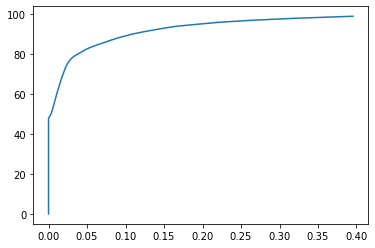

Distrubution of average AST depth


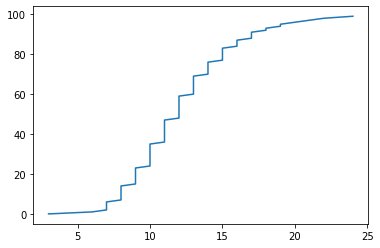

Distrubution of # ast leaves per code


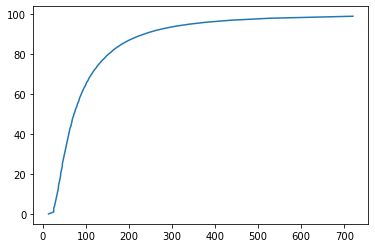

Distrubution of # dfg nodes per code


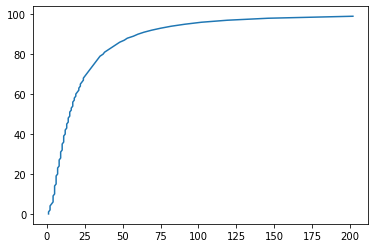

Distrubution of # dfg edges per code


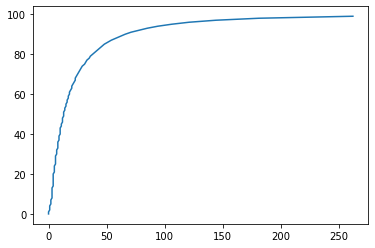

In [40]:
def some_more_stats(data):
    data['lr_paths_types'] = data['lr_paths_types'].progress_apply(lambda s:parse_list_of_lists(s, type_=int))
    node_types= pickle.load(open('data/pretrain/all_node_types.pkl','rb'))
    if 'ERROR' in node_types:
        error_node_idx = node_types.index('ERROR')
        num_error_nodes = data['lr_paths_types'].apply(lambda paths:np.mean([(np.array(path)==error_node_idx).max() 
                                                                      for path in paths]))
        print ('Distrubution of fraction of leaf-root paths with ERROR node in one code')
        length_stats(num_error_nodes)
    print ('Distrubution of AST depth')
    length_stats(data['lr_paths_types'].apply(lambda paths:max([len(p) for p in paths])))        
        
    print ('Distrubution of # ast leaves per code')
    length_stats(data['ast_leaf_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg nodes per code')
    length_stats(data['dfg_node_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg edges per code')
    def num_dfg_edges(s):
        if s=='[]':
            return 0
        return sum([t.split(', ',maxsplit=1)[1].count(',')+1 for t in s[1:-2].split('),')])
    length_stats(data['dfg_edges'].apply(num_dfg_edges))
    
data = []
save_dir = 'data/pretrain/'
for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='fastparquet')
        data.append(sub_data)
        
data = pd.concat(data)
    
some_more_stats(data)

In [9]:
from sys import getsizeof
getsizeof(data)/1e6

3599.548642

In [11]:
for col in data.columns:
    print (col, getsizeof(data[col])/1e6)

code_tokens 8.202777
text_tokens 2.978546
lang 0.612203
ast_leaf_code_token_idxs 10.205631
ll_sims 3559.75692
lr_paths_types 10.762512
dfg_node_code_token_idxs 3.453409
dfg_edges 3.577652
